In [1]:
import os
import dill
import bilby
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm

from util import (
    plot_single_evolution, violinplot, plot_multiple_lower_dim, dpi_key_to_label, 
    HYBRID_INIT_COLOR, HYBRID_COLOR, HYBRID_OVERLAP0_COLOR, COMP_COLOR, HYBRID_EVOL_COLORS
)

%load_ext autoreload
%autoreload 2

plt.style.use("./tgr-hybrid-sampling.mplstyle")

# Overlap Comparison Corner Plot (Figure 8)

## Time + Phase Maximized

Load results from the first step of the hybrid sampling procedure, generated with `dynesty`.

In [2]:
dphi2_step1_tm_posterior = pd.read_hdf("./GW150914_results/150914_hybrid_step1_time-maximized.hdf5", key="gr")

# add junk data for the missing dimension, d_phi_2, so we can
# plot it with the step2 results
dphi2_step1_tm_posterior["d_phi_2"] = np.random.normal(
    loc = 100, 
    scale = 0.1,
    size = len(dphi2_step1_tm_posterior)
)

res_dphi2_step1_tm = bilby.core.result.Result(
    posterior = dphi2_step1_tm_posterior,
    search_parameter_keys = list(dphi2_step1_tm_posterior.columns)
)

Load results form the second step of hybrid sampling, generated with `ptemcee`.

In [3]:
dphi2_tm_posterior = pd.read_hdf("./GW150914_results/150914_hybrid_step2_time-maximized.hdf5", key="d_phi_2")
dphi2_overlap0_tm_posterior = pd.read_hdf("./GW150914_results/150914_hybrid_step2_time-maximized.hdf5", key="d_phi_2_no_overlap")

res_dphi2_tm = bilby.core.result.Result(
    posterior = dphi2_tm_posterior,
    search_parameter_keys = list(dphi2_tm_posterior.columns)
)

res_dphi2_overlap0_tm = bilby.core.result.Result(
    posterior = dphi2_overlap0_tm_posterior,
    search_parameter_keys = list(dphi2_overlap0_tm_posterior.columns)
)

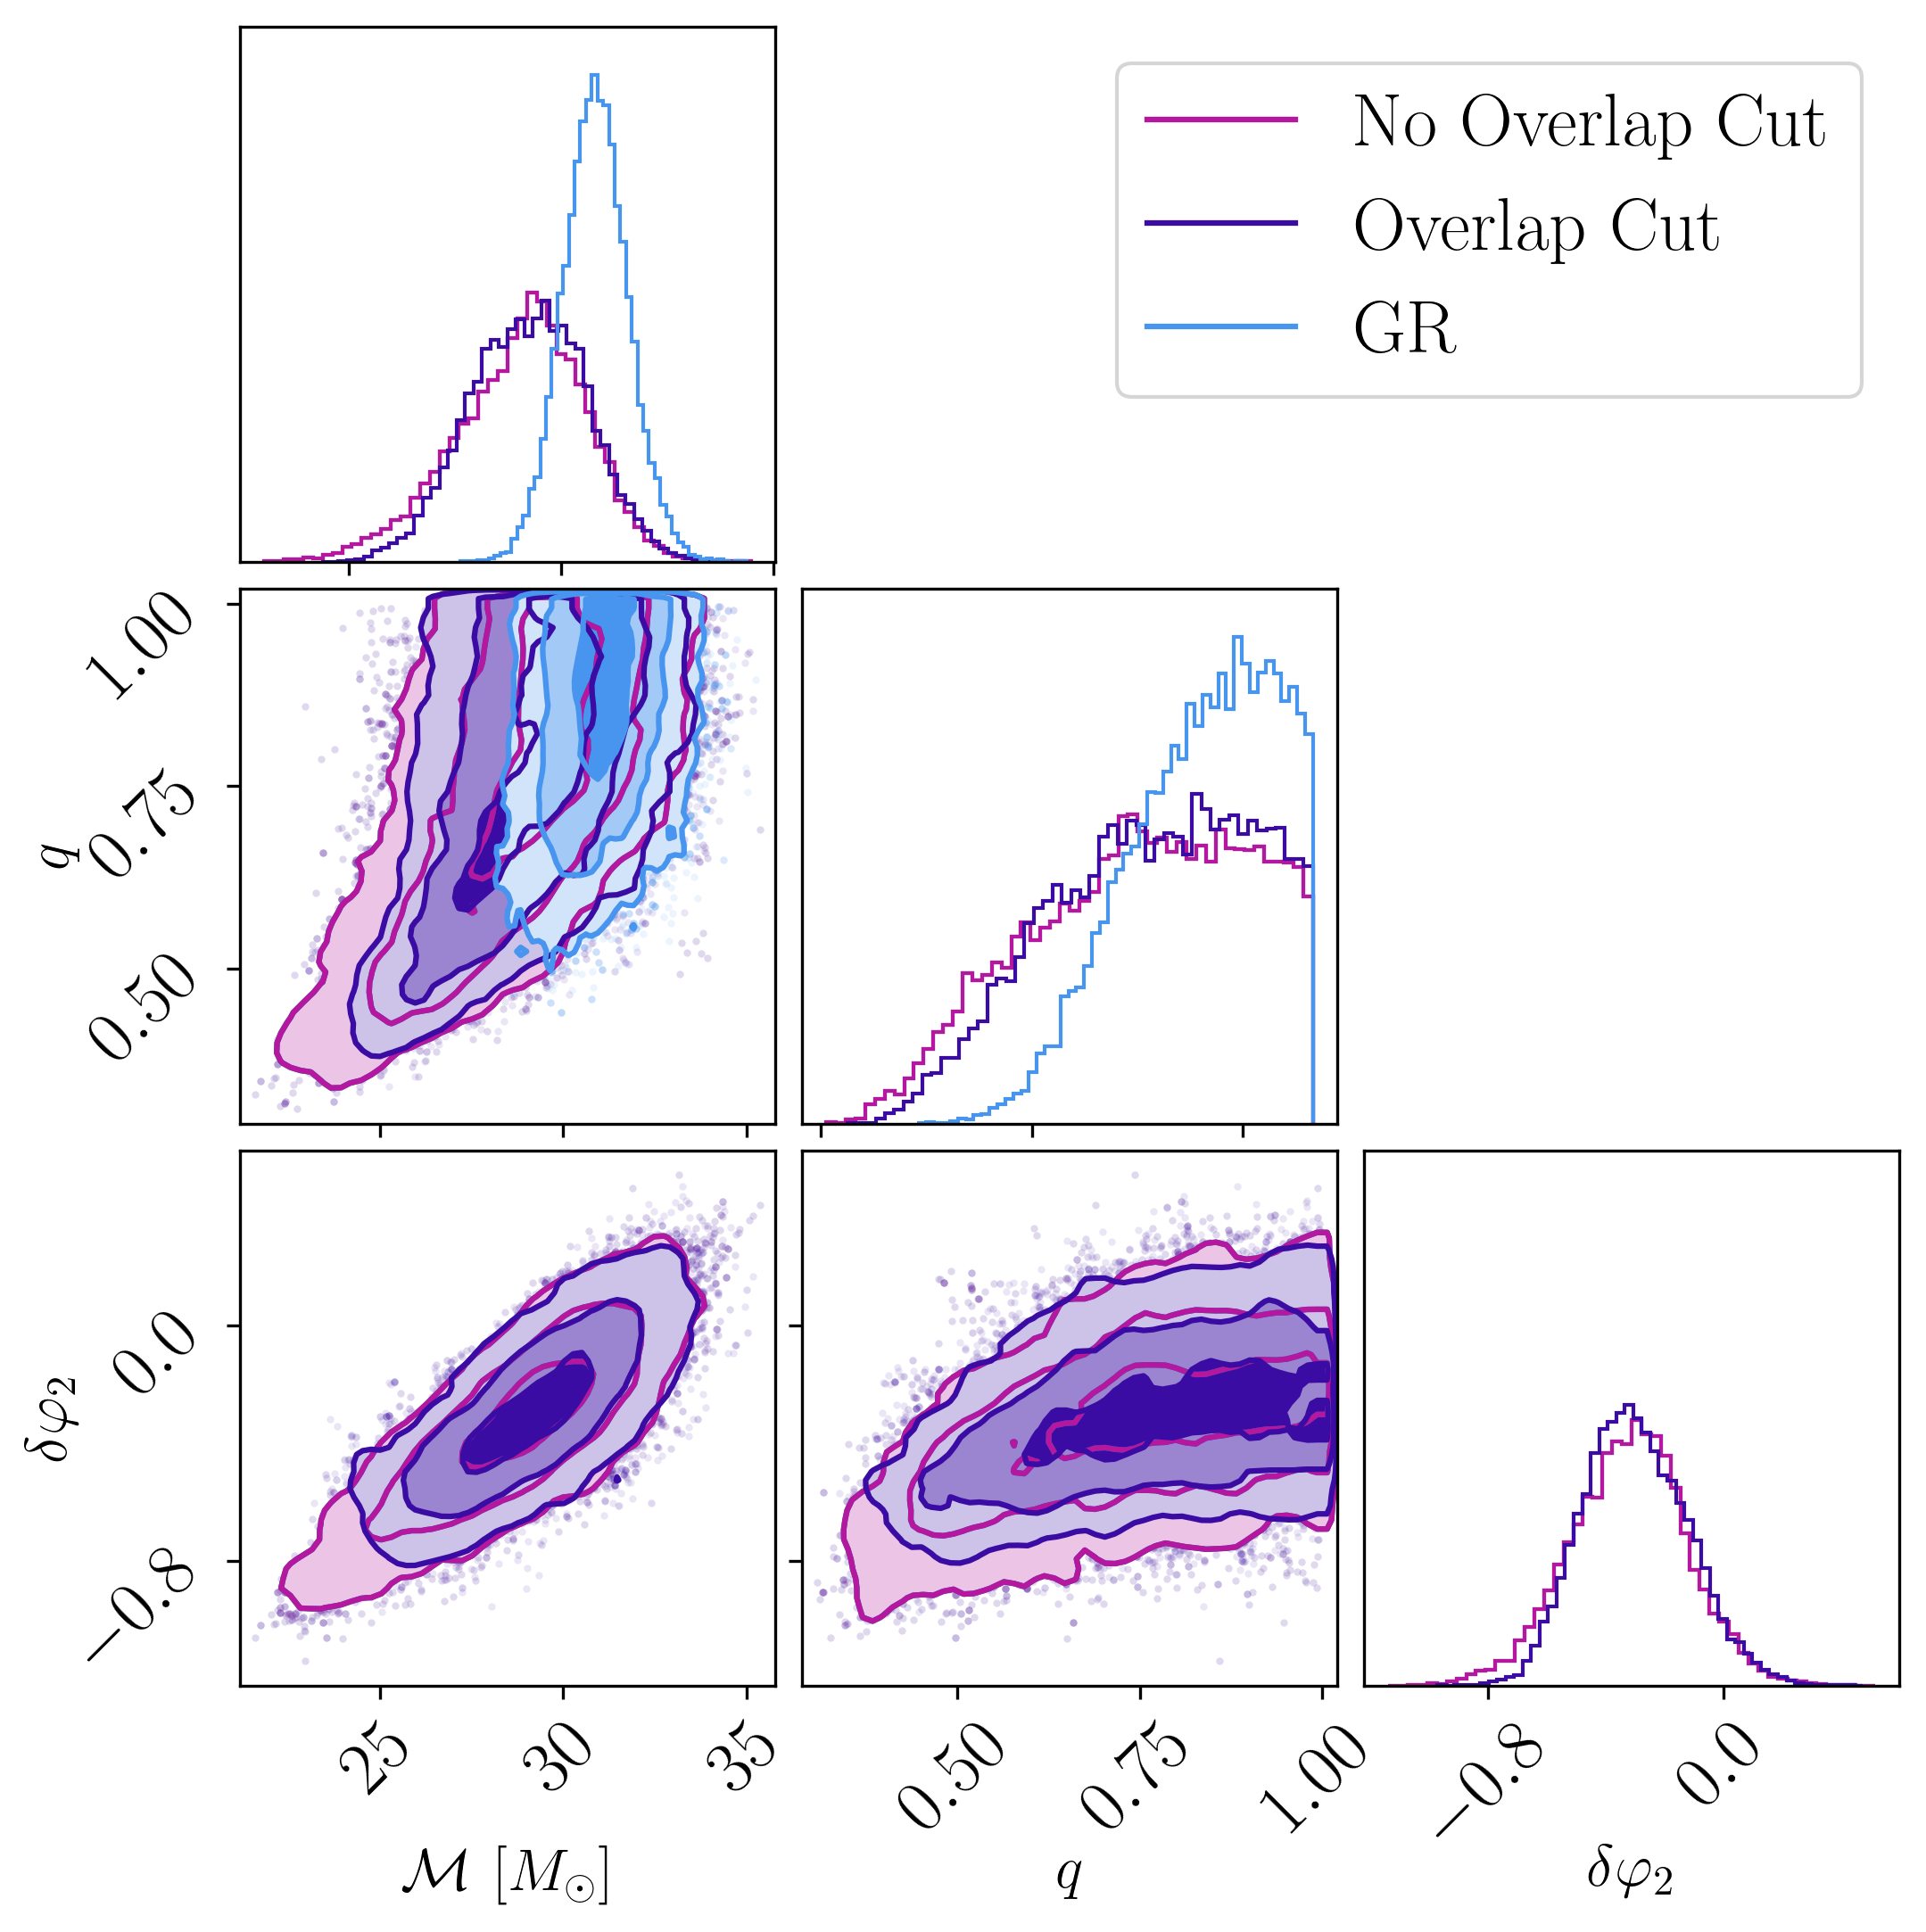

In [4]:
fig = plot_multiple_lower_dim(
    [res_dphi2_overlap0_tm, res_dphi2_tm], res_dphi2_step1_tm,
    labels = ["No Overlap Cut", "Overlap Cut", "GR"],
    titles = False,
    truth_color = "black",
    parameters = ["chirp_mass", "mass_ratio", "d_phi_2"],
    corner_labels = [
        r"$\mathcal{M}$ [$M_{\odot}$]", 
        r"$q$",
        dpi_key_to_label("d_phi_2")
    ],
    colours = [HYBRID_OVERLAP0_COLOR, HYBRID_COLOR, COMP_COLOR],
    quantiles = None
)

fig.savefig("./gw150914_dphi2_overlap-comparison_time-maximized.pdf", bbox_inches="tight")

## Only Phase Maximized

In [5]:
dphi2_step1_posterior = pd.read_hdf("./GW150914_results/150914_hybrid_step1.hdf5", key="gr")

# add junk data for the missing dimension, d_phi_2, so we can
# plot it with the step2 results
dphi2_step1_posterior["d_phi_2"] = np.random.normal(
    loc = 100, 
    scale = 0.1,
    size = len(dphi2_step1_posterior)
)

res_dphi2_step1 = bilby.core.result.Result(
    posterior = dphi2_step1_posterior,
    search_parameter_keys = list(dphi2_step1_posterior.columns)
)

In [6]:
dphi2_posterior = pd.read_hdf("./GW150914_results/150914_hybrid_step2.hdf5", key="d_phi_2")
dphi2_overlap0_posterior = pd.read_hdf("./GW150914_results/150914_hybrid_step2.hdf5", key="d_phi_2_no_overlap")

res_dphi2 = bilby.core.result.Result(
    posterior = dphi2_posterior,
    search_parameter_keys = list(dphi2_posterior.columns)
)

res_dphi2_overlap0 = bilby.core.result.Result(
    posterior = dphi2_overlap0_posterior,
    search_parameter_keys = list(dphi2_overlap0_posterior.columns)
)

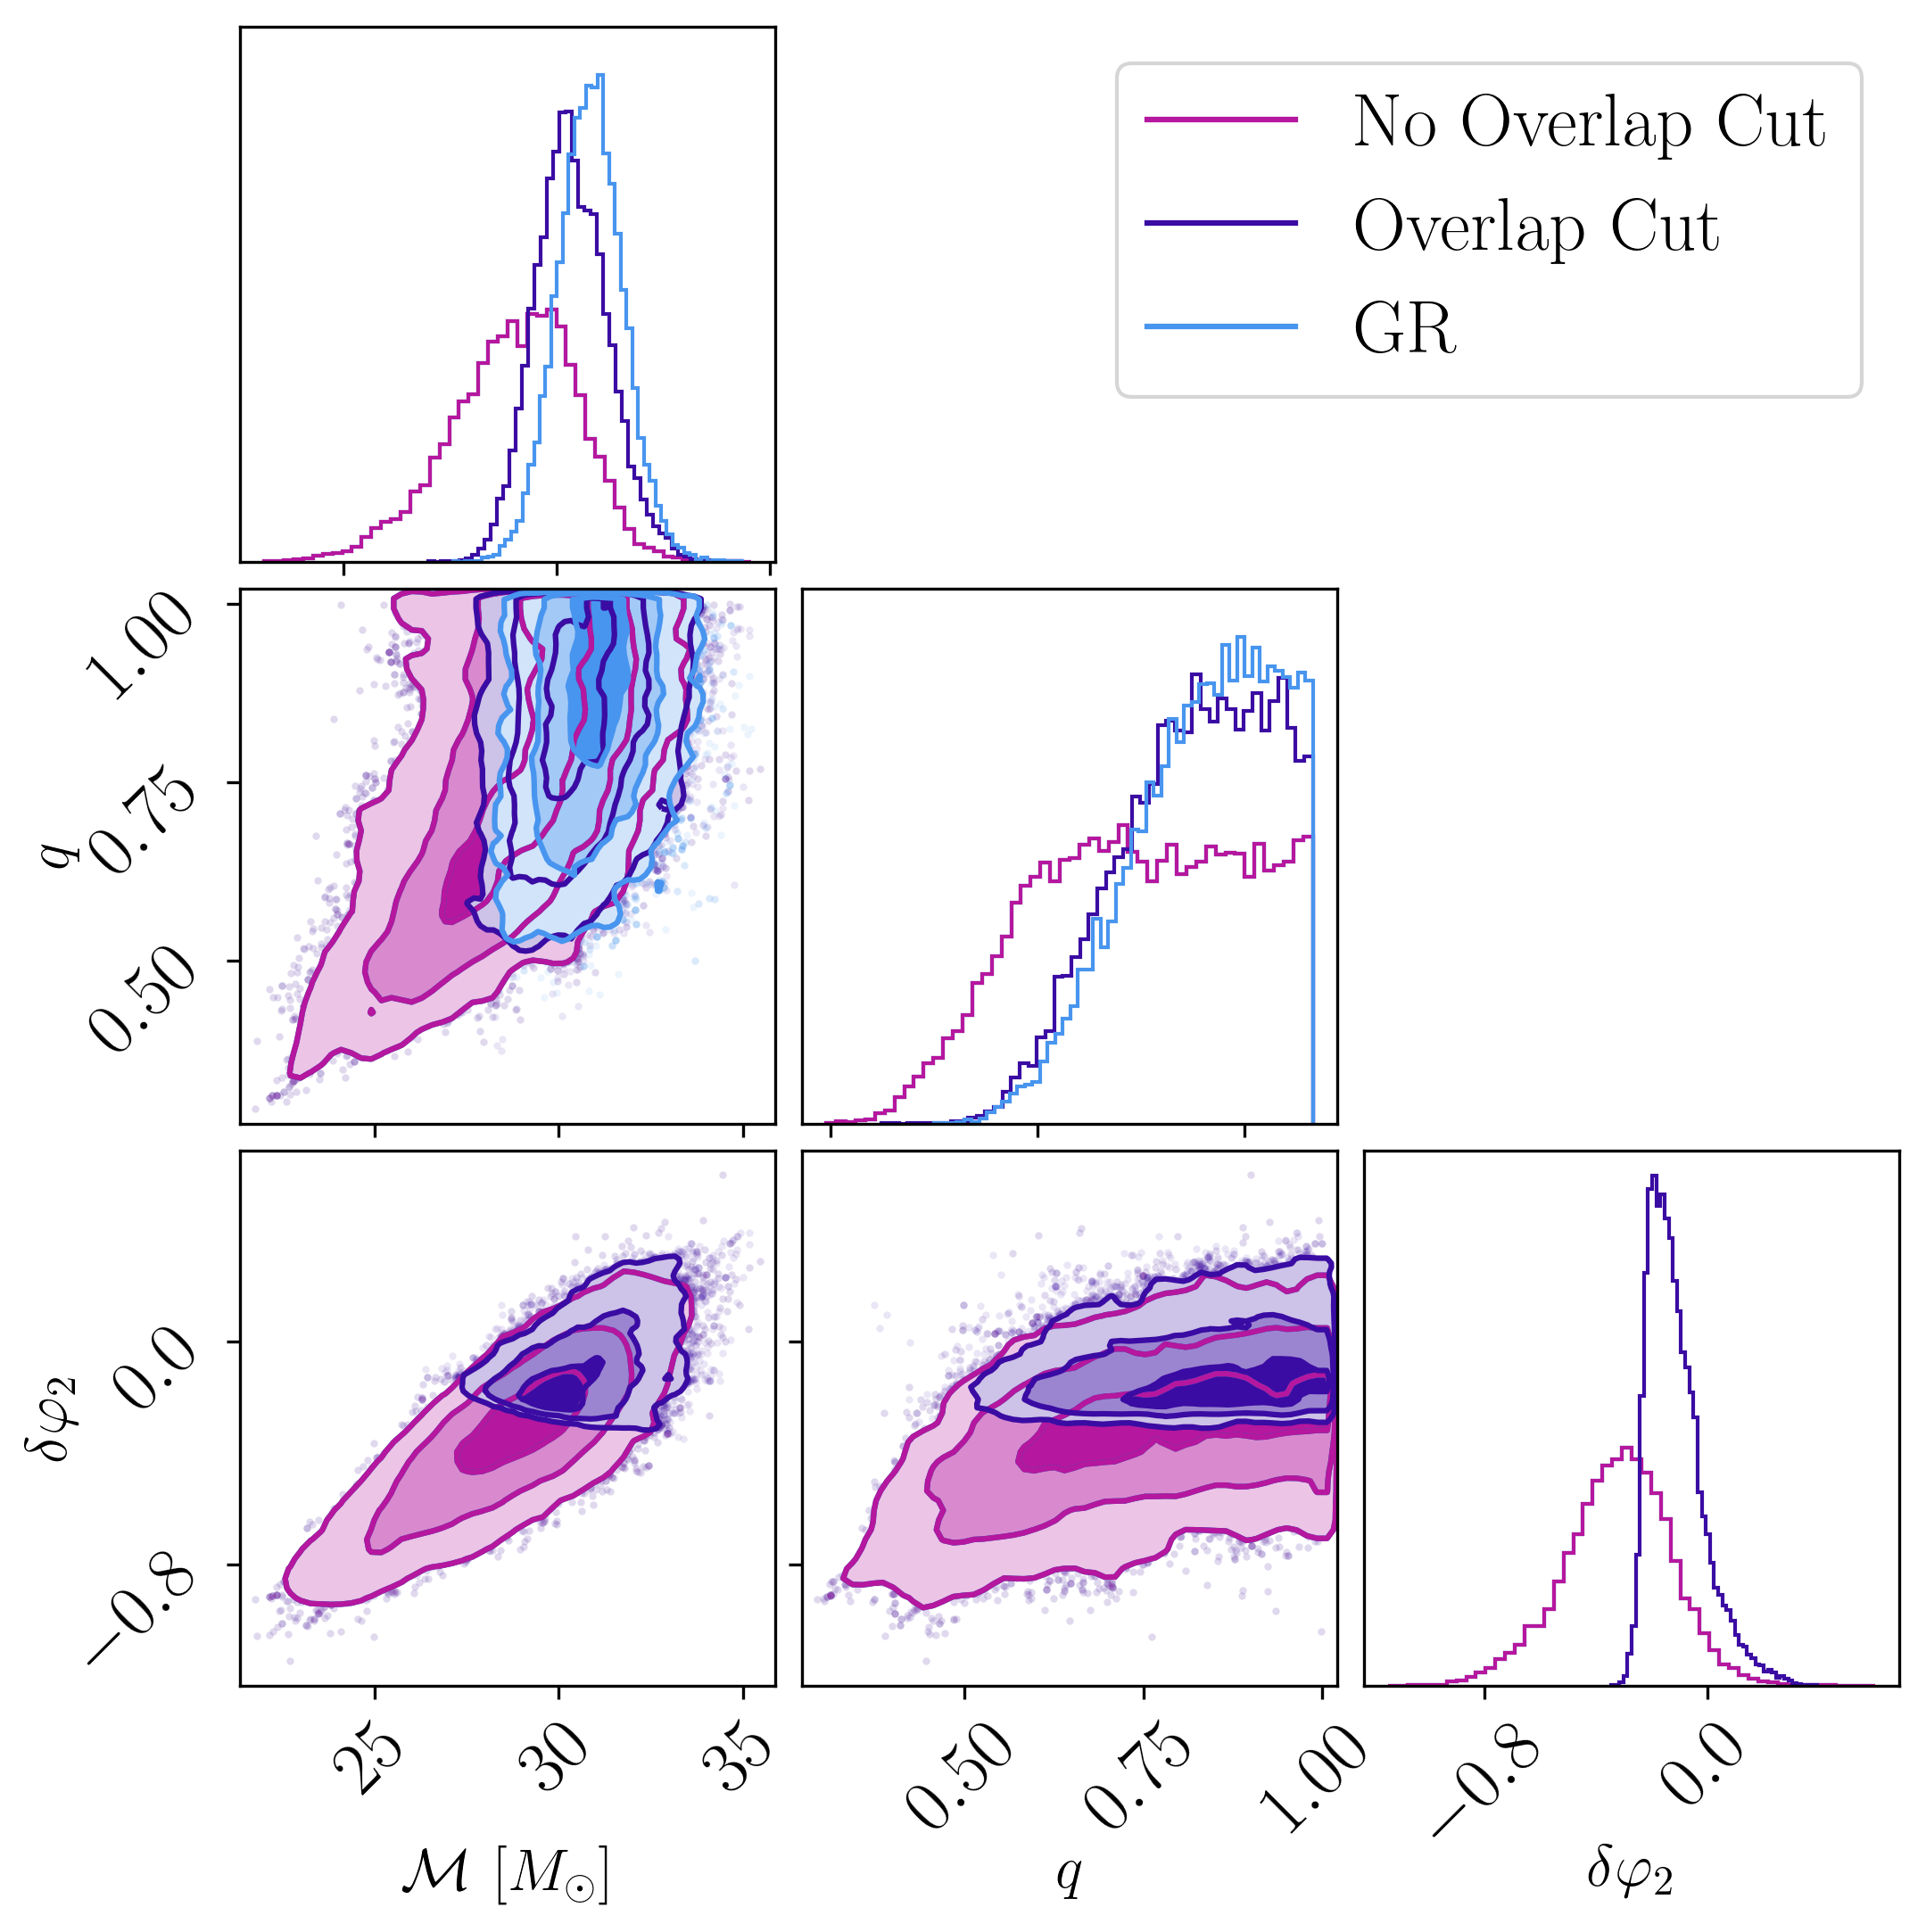

In [7]:
fig = plot_multiple_lower_dim(
    [res_dphi2_overlap0, res_dphi2], res_dphi2_step1,
    labels = ["No Overlap Cut", "Overlap Cut", "GR"],
    titles = False,
    truth_color = "black",
    parameters = ["chirp_mass", "mass_ratio", "d_phi_2"],
    corner_labels = [
        r"$\mathcal{M}$ [$M_{\odot}$]", 
        r"$q$",
        dpi_key_to_label("d_phi_2")
    ],
    colours = [HYBRID_OVERLAP0_COLOR, HYBRID_COLOR, COMP_COLOR],
    quantiles = None
)

fig.savefig("./gw150914_dphi2_overlap-comparison.pdf", bbox_inches="tight")

# Violinplot (Figure 7)

Load in results for all IMRPhenomPv2 deviation terms from the second step of hybrid sampling, with and without overlap cuts applied. 

In [8]:
all_dpi = [
    "d_phi_0",
    "d_phi_1",
    "d_phi_2",
    "d_phi_3",
    "d_phi_4",
    "d_phi_5L",
    "d_phi_6",
    "d_phi_6L",
    "d_phi_7",
    "d_alpha_2",
    "d_alpha_3",
    "d_alpha_4",
    "d_beta_2",
    "d_beta_3"
]

dpi_runs = dict()

for overlap in ["0.0", "0.9"]:
    for dpi in all_dpi:
        key = dpi
        if float(overlap) == 0:
            key += "_no_overlap"

        posterior = pd.read_hdf(f"./GW150914_results/150914_hybrid_step2_resume.hdf5", key=key)

        dpi_runs[(dpi, overlap, "hybrid")] = bilby.core.result.Result(
            posterior = posterior,
            samples = posterior.values,
            search_parameter_keys = list(posterior.columns),
        )

In [9]:
### load in results from TGR paper for the comparison result!
tgr_pi_params = [
    "dphi_0", 
    "dphi_1", 
    "dphi_2", 
    "dphi_3", 
    "dphi_4",
    "dphi_5l",
    "dphi_6",
    "dphi_6l",
    "dphi_7",
    "dalpha_2",
    "dalpha_3",
    "dalpha_4",
    "dbeta_2",
    "dbeta_3"
]

for dpi in tgr_pi_params:
    posterior = pd.read_hdf(
        "./GW150914_GWTC-1-TGR.hdf5", 
        key = f"{dpi}_IMRP_posterior"
    )

    dpi_key_nice = dpi.replace("d", "d_").replace("5l", "5L").replace("6l", "6L")
    posterior = posterior.rename(columns={dpi : dpi_key_nice})

    dpi_runs[(dpi_key_nice, "0.0", "comp")] = bilby.core.result.Result(
        posterior = posterior,
        search_parameter_keys = list( posterior.columns ),
        samples = np.array(posterior)
    )

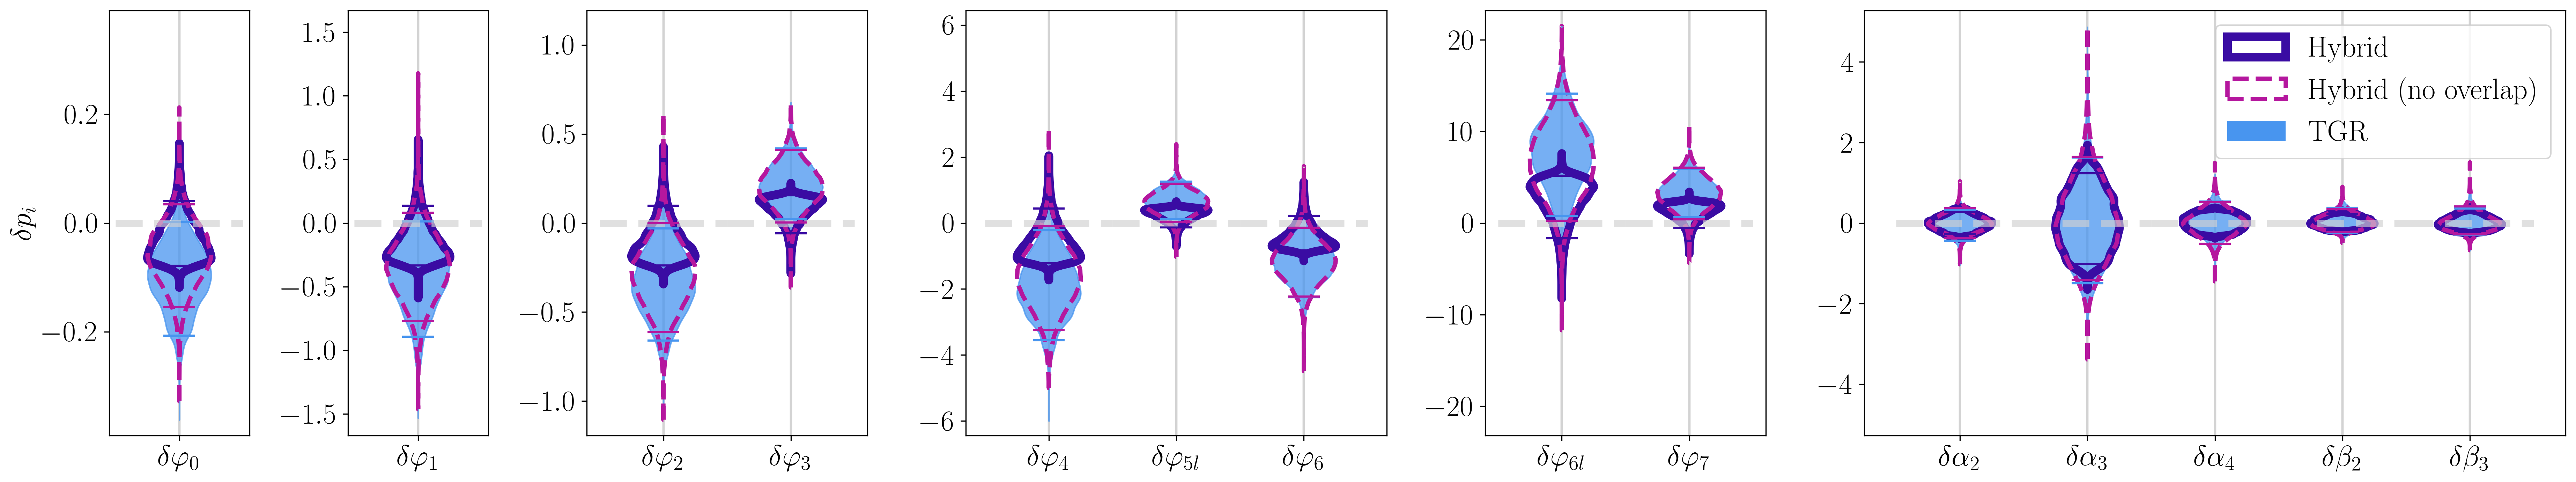

In [10]:
dpi_vals = dict(
    d_phi_0 = 0,
    d_phi_1 = 0,
    d_phi_2 = 0,
    d_phi_3 = 0,
    d_phi_4 = 0,
    d_phi_5L = 0,
    d_phi_6 = 0,
    d_phi_6L = 0,
    d_phi_7 = 0,
    d_alpha_2 = 0,
    d_alpha_3 = 0,
    d_alpha_4 = 0,
    d_beta_2 = 0,
    d_beta_3 = 0
)

fig, axes = violinplot(
    runs = dpi_runs, 
    param_key = "dpi", 
    truth = dpi_vals, 
    param_label = r"$\delta p_i$",
    labels = [ "Hybrid", "Hybrid (no overlap)", "TGR" ],
    fig_kwargs=dict(figsize=(25,5))
)

#fig.savefig("./gw150914_violinplot.pdf", bbox_inches="tight")

# Sampling Evolution (Figure 9)
Plot the evolution of the second step of hybrid sampling, the `ptemcee` sampler, without any overlap cut.

In [11]:
with open("./GW150914_results/150914_d_phi_2_no-overlap_resume.pickle", "rb") as f:
    dphi2_overlap0_resume = dill.load(f)

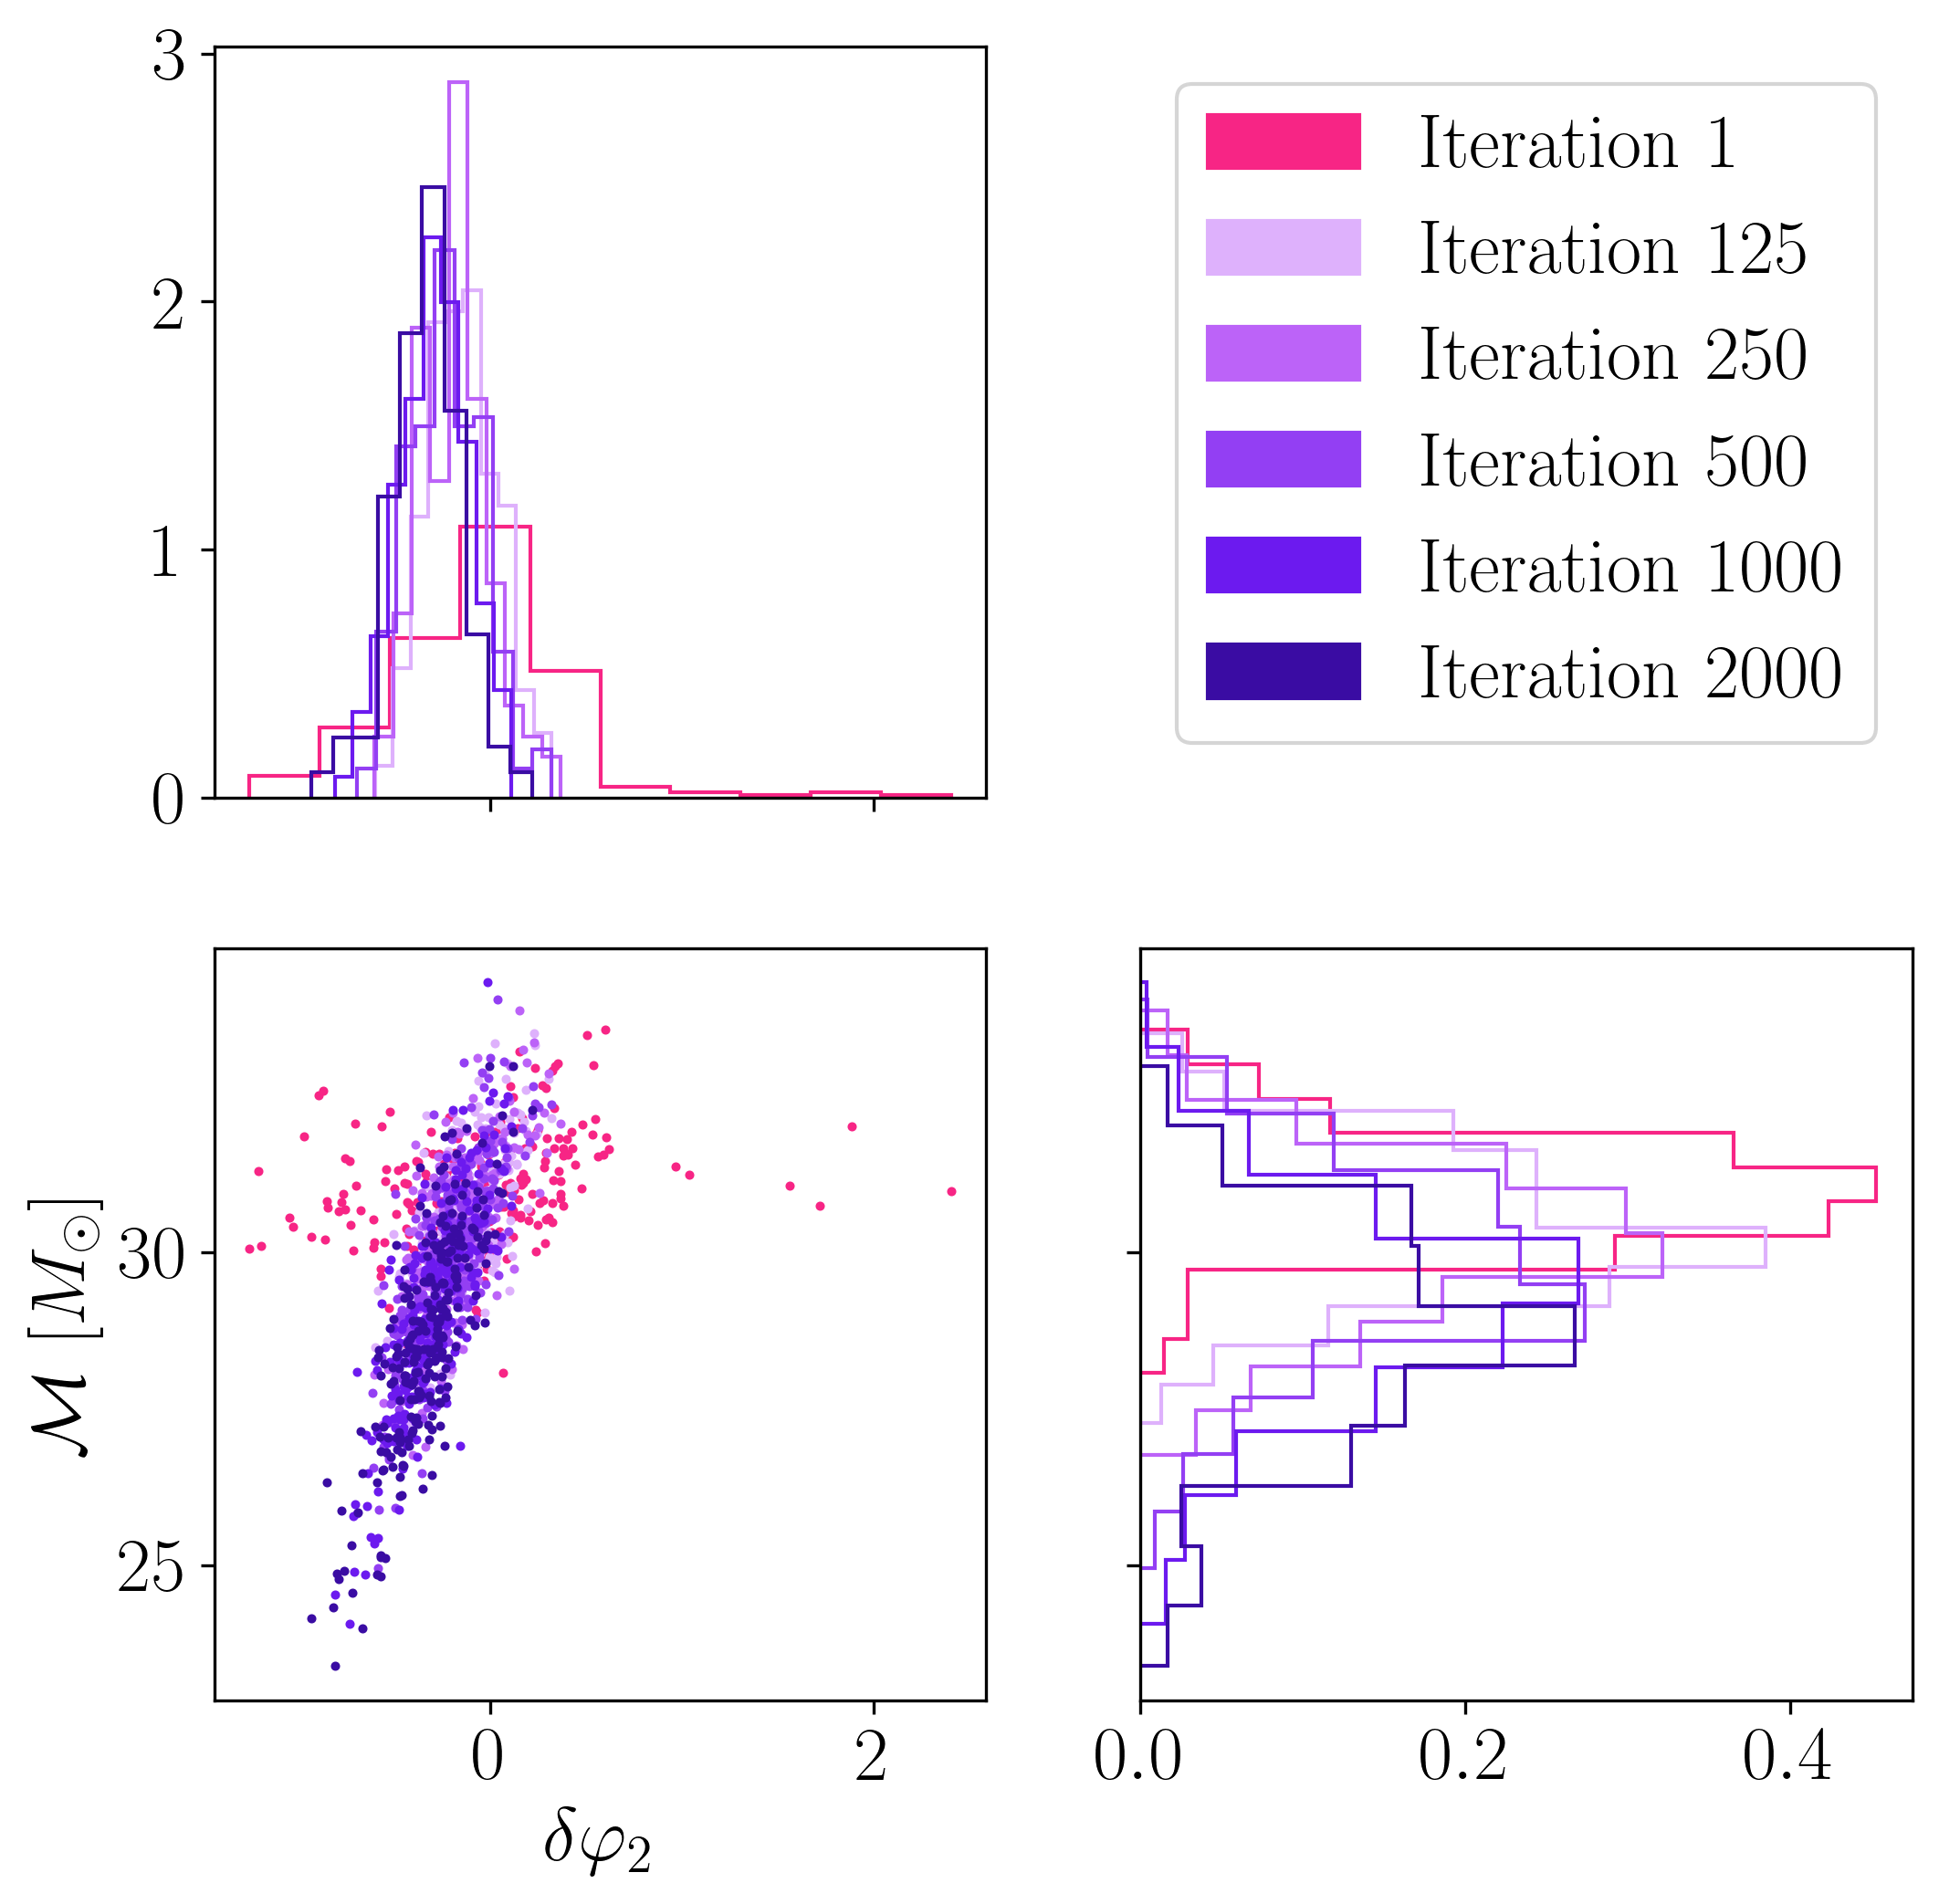

In [12]:
iterations = [1, 125, 250, 500, 1000, 2000]

fig = plot_single_evolution(
    res_dphi2_overlap0, dphi2_overlap0_resume, 
    "d_phi_2", "chirp_mass", 
    r"$\delta \varphi_2$", r"$\mathcal{M}$ [$M_{\odot}$]",
    iterations = np.array(iterations) - 1,
    xidx_override = 12
)

fig.get_axes()[1].legend(
    [ 
        mpl.patches.Patch(facecolor=c, edgecolor=c) 
        for c in [HYBRID_INIT_COLOR] + HYBRID_EVOL_COLORS[:len(iterations) - 1] ] + [ mpl.patches.Patch(facecolor="#FF8C00", edgecolor="#FF8C00") 
    ],
    [ f"Iteration %d" % it for it in iterations ],
    loc = "upper center"
)

fig.savefig("./150914_evolution_d_phi_2_no_overlap.pdf", bbox_inches="tight")